In [10]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns
import os
from sklearn.cluster import KMeans
import utils
from tqdm import tqdm 
from sklearn.preprocessing import MinMaxScaler

os.sys.path.append('../../../')
from mesa import multiomics

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

## Prepare Data for Multiomics Integration

We begin by reading in CODEX and scRNASeq data.

In [4]:
# read in CODEX data
data_dir = '../../../../../tonsil/'
protein = pd.read_csv(os.path.join(data_dir, 'tonsil_codex.csv'))

Let's visualize the CODEX data. Here each cell is colored by cell type.

<Axes: xlabel='centroid_x', ylabel='centroid_y'>

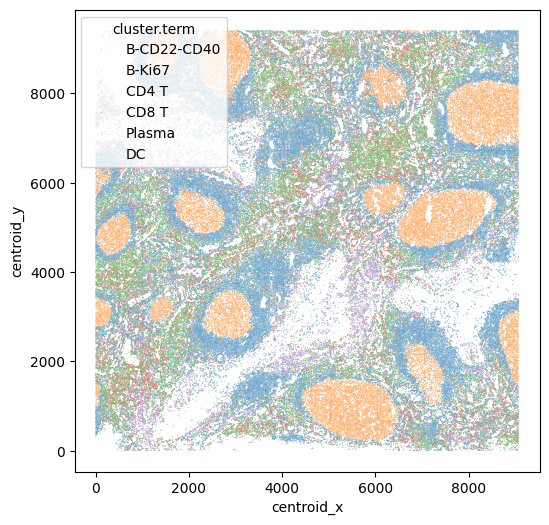

In [4]:
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue = "cluster.term", s = 0.3)

In [8]:
# input csv contains meta info, take only protein features
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
# convert to AnnData
protein_adata = ad.AnnData(
    protein[protein_features].to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein[protein_features].columns

Then we read in the scRNASeq data and convert to ```adata``` format too.

In [9]:
# read in RNA data
rna = mmread("../../../../../tonsil/tonsil_rna_counts.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../../../../../tonsil/tonsil_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

In [10]:
rna_adata_raw = rna_adata

Here we are integrating protein and RNA data, and most of the time there are name differences between protein (antibody) and their corresponding gene names. To construct the feature correspondence in straight forward way, we prepared a ```.csv``` file containing most of the antibody name (seen in cite-seq or codex antibody names etc) and their corresponding gene names:


In [11]:
correspondence = pd.read_csv('../../../../../tonsil/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


But of course this files does contain all names including custom names in new assays. If a certain correspondence is not found, either it is missing in the other modality, or you should customly add the name conversion to this ```.csv``` file.

In [12]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [13]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

In [14]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.5) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(12977, 32), (178919, 32)]


We apply standard Scanpy preprocessing steps to `rna_shared`.
We skipped the processing steps for `protein_shared` because the input CODEX data was already normalized et.

In [15]:
# process rna_shared
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)
rna_shared = rna_shared.X.copy()

In [16]:
protein_shared = protein_shared.X.copy()

We again apply standard Scanpy preprocessing steps to **all available RNA measurements and protein measurements** (not just the shared ones) to get two arrays, `rna_active` and `protein_active`, which are used for iterative refinement. Again if the input data is already processed, these steps can be skipped.

In [17]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [18]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

## Multiomics Integration 

While we are using the MaxFuse method for multiomics integration in MESA, other integration methods can also be implemented. For more detailed documentation of MaxFuse, please check out: https://maxfuse.readthedocs.io/en/latest/index.html.

### Step I: preparations

In [19]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

To reduce computational complexity, we call `split_into_batches` to fit the batched version of MaxFuse.

In [20]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 12977, and max batch size is 12977.
The second data is split into 5 batches, average batch size is 35783, and max batch size is 35787.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4'].


The next step is to construct appropriate nearest-neighbor graphs for each modality with all features available.
But before that, we plot the singular values of the two active arrays to determine how many principal components (PCs) to keep when doing graph construction.

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

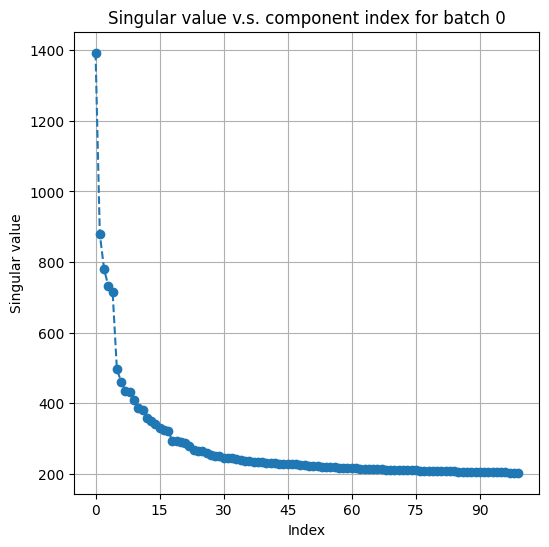

In [21]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 1'}, xlabel='Index', ylabel='Singular value'>)

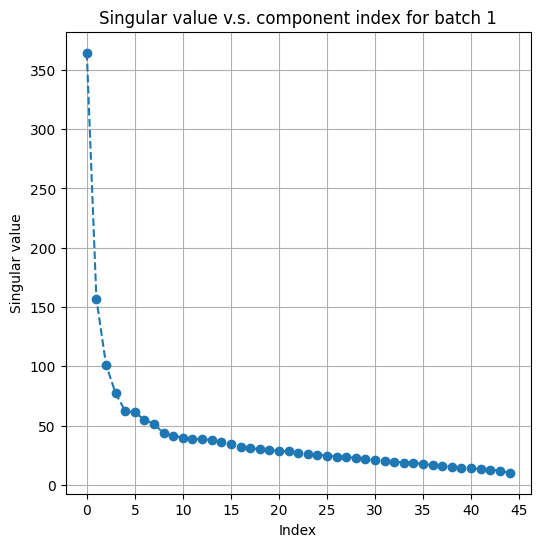

In [22]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

Inspecting the "elbows", we choose the number of PCs to be **40** for both RNA and  **15** for protein active data.
We then call `construct_graphs` to compute nearest-neighbor graphs as needed.

In [23]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=15,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph clustering finished!


### Step II: finding initial pivots

We then use shared arrays whose columns are matched to find initial pivots.
Before we do so, we plot top singular values of two shared arrays to determine how many PCs to use.

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

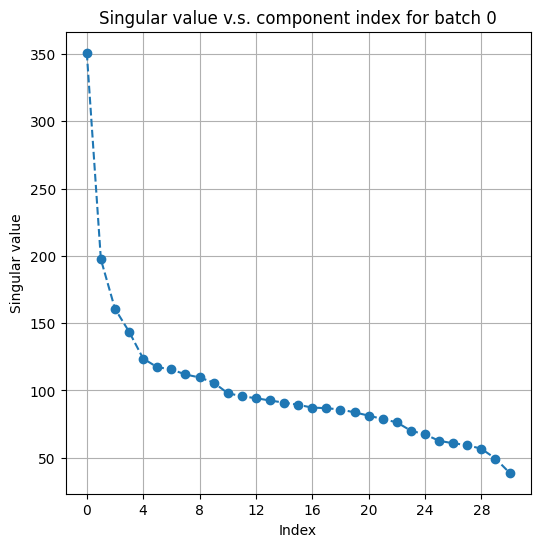

In [24]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 3'}, xlabel='Index', ylabel='Singular value'>)

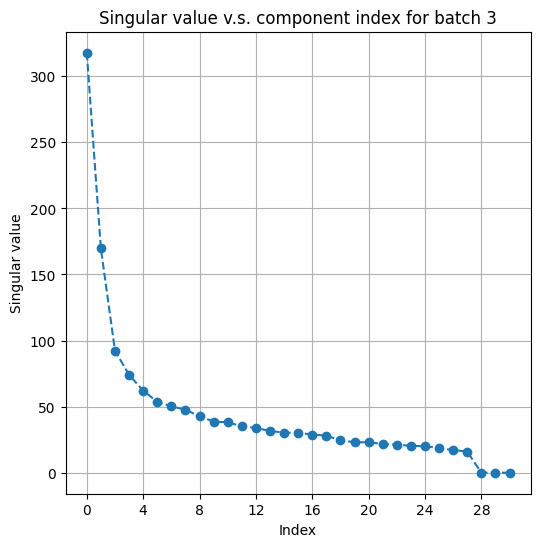

In [25]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

We choose to use **25** PCs for ``rna_shared`` and **20** PCs for ``protein_shared``. We then call ``find_initial_pivots`` to compute initial set of matched pairs.

In [26]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


Now, we have a set of *initial pivots* that store the matched pairs when only the information in the shared arrays is used. The information on initial pivots are stored in the internal field ``fusor._init_matching`` that is invisible to users.

### Step III: finding refined pivots

We now use the information in active arrays to iteratively refine initial pivots.
We plot the top canonical correlations to choose the best number of components in canonical correlation analysis (CCA).

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

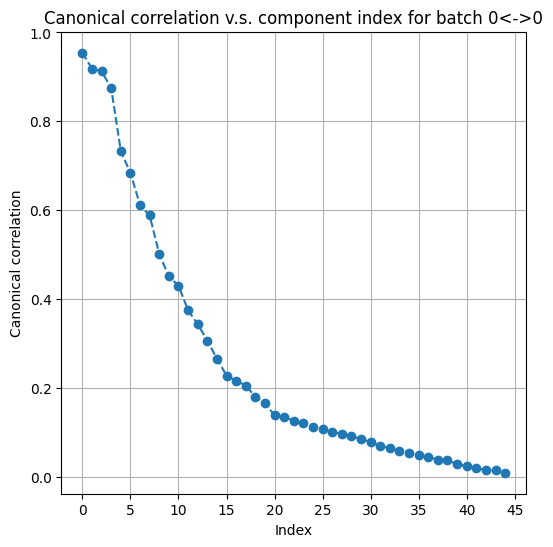

In [27]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

A quick check on the previous plot gives a rough guide on what the `refine_pivots` parameters should be picked.

**Note:** here that the `n_iters` number we choosed *1*, as in low snr datasets (eg. spatial-omis) increase amount of iteration might degrade the performance.

In [28]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


**Note:** here we can see `filter_prop` we increased the pivot filtering to *0.5* compared to previous example. We found harsher filtering for integrations that involves spatial-omics is more beneficial.

In [29]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
16245/32485 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
9567/12977 cells in arr1 are selected as pivots.
16245/178919 cells in arr2 are selected as pivots.
Done!


### Step IV: propagation

Refined pivots can only give us a pivot matching that captures a subset of cells. In order to get a *full* matching that involves all cells during input, we need to call `propagate`.


In [30]:
fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


We call `filter_bad_matches` with `target=propagated` to optionally filter away a few matched pairs from propagation. 

**Note:** In the best scenario, we would prefer all cells in the *full* dataset can be matched accross modality. However, in the case that invovles *low-snr* datasets (eg. spatial-omics), many cells are noisy (or lack of information) and should not be included in downstream cross-modality analysis. We suggest in such scenarios, `filter_prop` should be set around *0.1-0.4*.

In [31]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
125238/178914 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


We use `get_matching` with `target='full_data'` to extract the full matching.

Because of the batching operation, the resulting matching may contain duplicates. The `order` argument determines how those duplicates are dealt with. 
`order=None` means doing nothing and returning the matching with potential duplicates;
`order=(1, 2)` means returning a matching where each cell in the first modality contains *at least one match* in the second modality;
`order=(2, 1)` means returning a matching where each cell in the second modality contains *at least one match* in the first modality.

**Note:** Since we filtered out some cell pairs here, not all cells in the full dataset has matches.

In [32]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [41]:
len(full_matching[0])

141438

Since we are doing `order=(2, 1)` here, the matching info is all the cells (10k) in mod 2 (protein) has at least one match cell in the RNA modality. Note that the matched cell in RNA could be duplicated, as protein cells could be matched to the same RNA cell. For a quick check on matching format:

In [33]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,11555,0,0.677698
1,12419,13,0.829264
2,6964,26,0.743796
3,12027,35,0.633725
4,3463,38,0.873877
...,...,...,...
141433,6516,178913,0.650691
141434,6380,178915,0.752489
141435,11798,178916,0.624662
141436,6516,178917,0.598526


Saving the results...

In [42]:
df_res = pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
#df_res.to_csv('tonsil_codex_rna.csv', index=False)

## Neighborhood Characterization


In [5]:
# protein expression in protein
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
protein_exp = protein[protein_features]

### Cellular Composition-based Neighborhoods

In [11]:
# Get neighborhood composition
ks = 20
locations = protein[['centroid_x', 'centroid_y']].values
feature_labels = protein['cluster.term'].values
spatial_knn_indices = multiomics.multiomics_spatial.get_spatial_knn_indices(locations=locations, n_neighbors=ks, method='kd_tree') 
cell_nbhd = utils.get_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels)

In [12]:
n_cluster = 10
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(cell_nbhd)
#print(kmeans.labels_)
protein['cluster_composition'] = kmeans.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
order_clusters_composition

NameError: name 'order_clusters_composition' is not defined

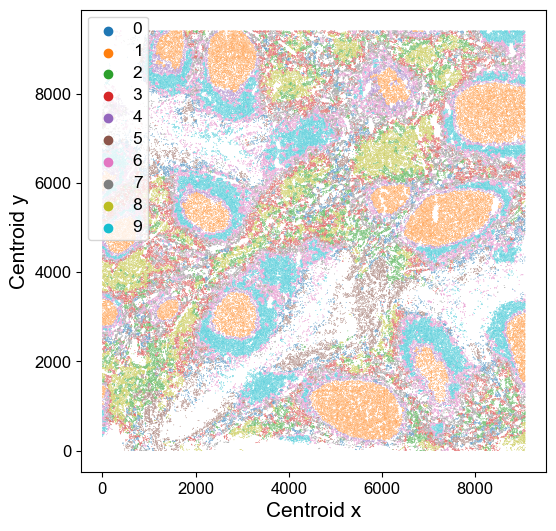

In [14]:
cell_type_order = sorted(protein['cluster.term'].unique())
order_clusters_composition = sorted(protein['cluster_composition'].unique())

plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_composition", 
                hue_order=order_clusters_composition, s = 0.3, rasterized=True)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_ct_composition.png')
#plt.savefig('../figures/tonsil/tonsil_ct_composition.svg', dpi=300)
plt.show()

### MESA's Local Average Protein Expression-based Neighborhoods

In [41]:
avg_exp = mesa.multiomics.multiomics_spatial.get_avg_expression_neighbors(protein_exp, spatial_knn_indices)
avg_exp_df = np.stack(avg_exp)

Computing avg expression: 100%|██████████| 178919/178919 [00:21<00:00, 8293.29it/s]


In [42]:
n_cluster = 10
kmeans_protein = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_df)
protein['cluster_protein'] = kmeans_protein.labels_.astype(str)

In [43]:
# reorder colors to be consistent
order_clusters_protein = sorted(protein['cluster_protein'].unique())
protein['cluster_protein_order'] = protein['cluster_protein']
index1 = protein[protein['cluster_protein_order'] == '1'].index
index2 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index1, 'cluster_protein_order'] = '9'
protein.loc[index2, 'cluster_protein_order'] = '1'

index3 = protein[protein['cluster_protein_order'] == '7'].index
index4 = protein[protein['cluster_protein_order'] == '2'].index
protein.loc[index3, 'cluster_protein_order'] = '2'
protein.loc[index4, 'cluster_protein_order'] = '7'

index5 = protein[protein['cluster_protein_order'] == '0'].index
index6 = protein[protein['cluster_protein_order'] == '5'].index
protein.loc[index5, 'cluster_protein_order'] = '5'
protein.loc[index6, 'cluster_protein_order'] = '0'

index7 = protein[protein['cluster_protein_order'] == '2'].index
index8 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index7, 'cluster_protein_order'] = '9'
protein.loc[index8, 'cluster_protein_order'] = '2'

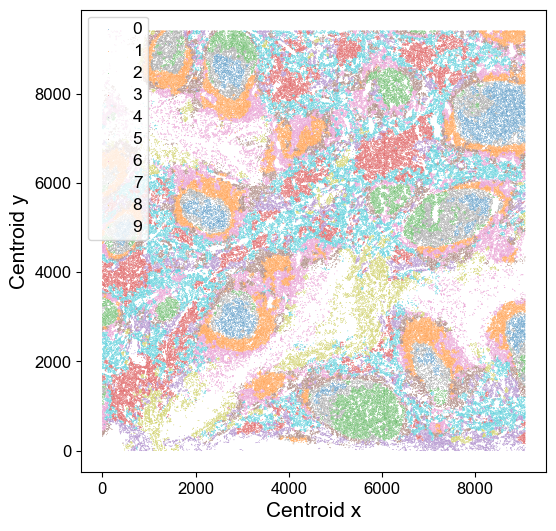

In [44]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_protein_order", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_avgprotein_order.png')
#plt.savefig('../figures/tonsil/tonsil_avgprotein_order.svg', dpi=300)
#plt.show()

### MESA's Local Average mRNA Expression-based Neighborhoods

We first load the integration results.

In [46]:
df_rna_match = pd.read_csv('../../../../../tonsil/tonsil_codex_rna.csv')
df_rna_match.columns = ['rna', 'protein', 'score']

In [47]:
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()

rna_exp = rna_adata.X.toarray()

In [49]:
# assign in-silico matched rna expression to cells in CODEX data
rna_matched = []
for i in tqdm(range(protein.shape[0]), total=protein.shape[0], desc='Assigning rna expression'):
    if i in df_rna_match['protein'].values:
        rna_idx = df_rna_match[df_rna_match['protein'] == i]['rna']
        rna_exp_each = rna_exp[rna_idx][0]
        rna_matched.append(rna_exp_each)
    else:
        rna_matched.append(np.array([0]*rna_exp.shape[1]))

Assigning rna expression: 100%|██████████| 178919/178919 [00:33<00:00, 5271.49it/s]


In [50]:
rna_matched_protein_order = np.stack(rna_matched)
rna_matched_df = pd.DataFrame(rna_matched_protein_order)

# calculate the average rna expression based on rna_matched_protein_order for each cluster
avg_exp_rna = utils.get_avg_expression_neighbors(rna_matched_df, spatial_knn_indices)
avg_exp_rna_df = np.stack(avg_exp_rna)

Computing avg expression: 100%|██████████| 178919/178919 [00:49<00:00, 3588.70it/s]


In [51]:
n_cluster = 10
kmeans_rna = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_rna_df)
protein['cluster_rna'] = kmeans_rna.labels_.astype(str)

In [52]:
# reorder colors to be consistent
order_clusters_rna = sorted(protein['cluster_rna'].unique())
protein['cluster_rna_order'] = protein['cluster_rna']

index1 = protein[protein['cluster_rna_order'] == '1'].index
index2 = protein[protein['cluster_rna_order'] == '8'].index
protein.loc[index1, 'cluster_rna_order'] = '8' 
protein.loc[index2, 'cluster_rna_order'] = '1' 
index3 = protein[protein['cluster_rna_order'] == '2'].index
index4 = protein[protein['cluster_rna_order'] == '3'].index
protein.loc[index3, 'cluster_rna_order'] = '3' 
protein.loc[index4, 'cluster_rna_order'] = '2' 
index5 = protein[protein['cluster_rna_order'] == '2'].index
index6 = protein[protein['cluster_rna_order'] == '4'].index
protein.loc[index5, 'cluster_rna_order'] = '4' 
protein.loc[index6, 'cluster_rna_order'] = '2' 
index7 = protein[protein['cluster_rna_order'] == '5'].index
index8 = protein[protein['cluster_rna_order'] == '0'].index
protein.loc[index7, 'cluster_rna_order'] = '0' 
protein.loc[index8, 'cluster_rna_order'] = '5' 
index9 = protein[protein['cluster_rna_order'] == '4'].index
index10 = protein[protein['cluster_rna_order'] == '8'].index
protein.loc[index9, 'cluster_rna_order'] = '8' 
protein.loc[index10, 'cluster_rna_order'] = '4' 

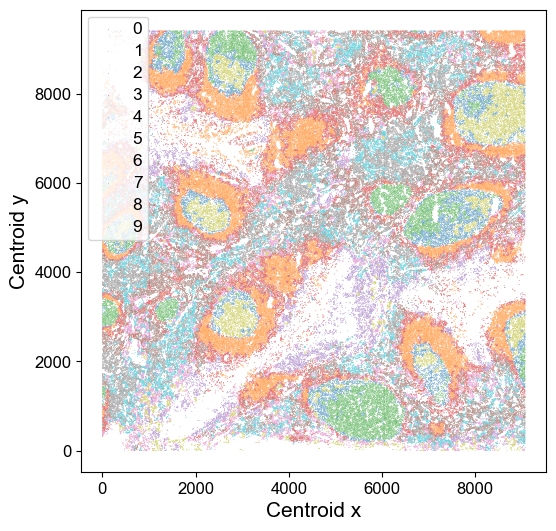

In [53]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_rna_order", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_avgrna_order.png')
#plt.savefig('../figures/tonsil/tonsil_avgrna_order.svg', dpi=300)
plt.show()

### Neighborhood Heatmap

In [54]:
# calculate the average protein expression for each cluster
protein['all_protein'] = protein_exp.values.tolist()
cluster_avg_exp = protein.groupby('cluster_protein_order')['all_protein'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_avg_exp = np.stack(cluster_avg_exp.values)
cluster_avg_exp = pd.DataFrame(cluster_avg_exp, columns=protein_features)

# calculate the average cellular composition based on cell_nbhd for each cluster
protein['composition'] = cell_nbhd.tolist()
cluster_composition = protein.groupby('cluster_protein_order')['composition'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_composition = np.stack(cluster_composition.values)
cluster_composition = pd.DataFrame(cluster_composition, columns=np.unique(list(feature_labels)))

# scale RNA expression to 0-1 to be comparable with protein expression
scaler = MinMaxScaler()
rna_matched_protein_order_scale = scaler.fit_transform(rna_matched_protein_order)
rna_matched_protein_order_scale = pd.DataFrame(rna_matched_protein_order_scale, columns=rna_adata.var_names)

# calculate the average RNA expression for each cluster
protein['all_rna'] = rna_matched_protein_order_scale.values.tolist()
cluster_avg_exp_rna = protein.groupby('cluster_protein_order')['all_rna'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_avg_exp_rna = np.stack(cluster_avg_exp_rna.values)
cluster_avg_exp_rna = pd.DataFrame(cluster_avg_exp_rna, columns=rna_matched_protein_order_scale.columns)

# select highly variable RNAs
var_rna = cluster_avg_exp_rna.var()
top_variance_columns = var_rna.sort_values(ascending=False).head(50)
top_variance_column_names = top_variance_columns.index.tolist()
cluster_avg_exp_rna_variable = cluster_avg_exp_rna[top_variance_column_names]

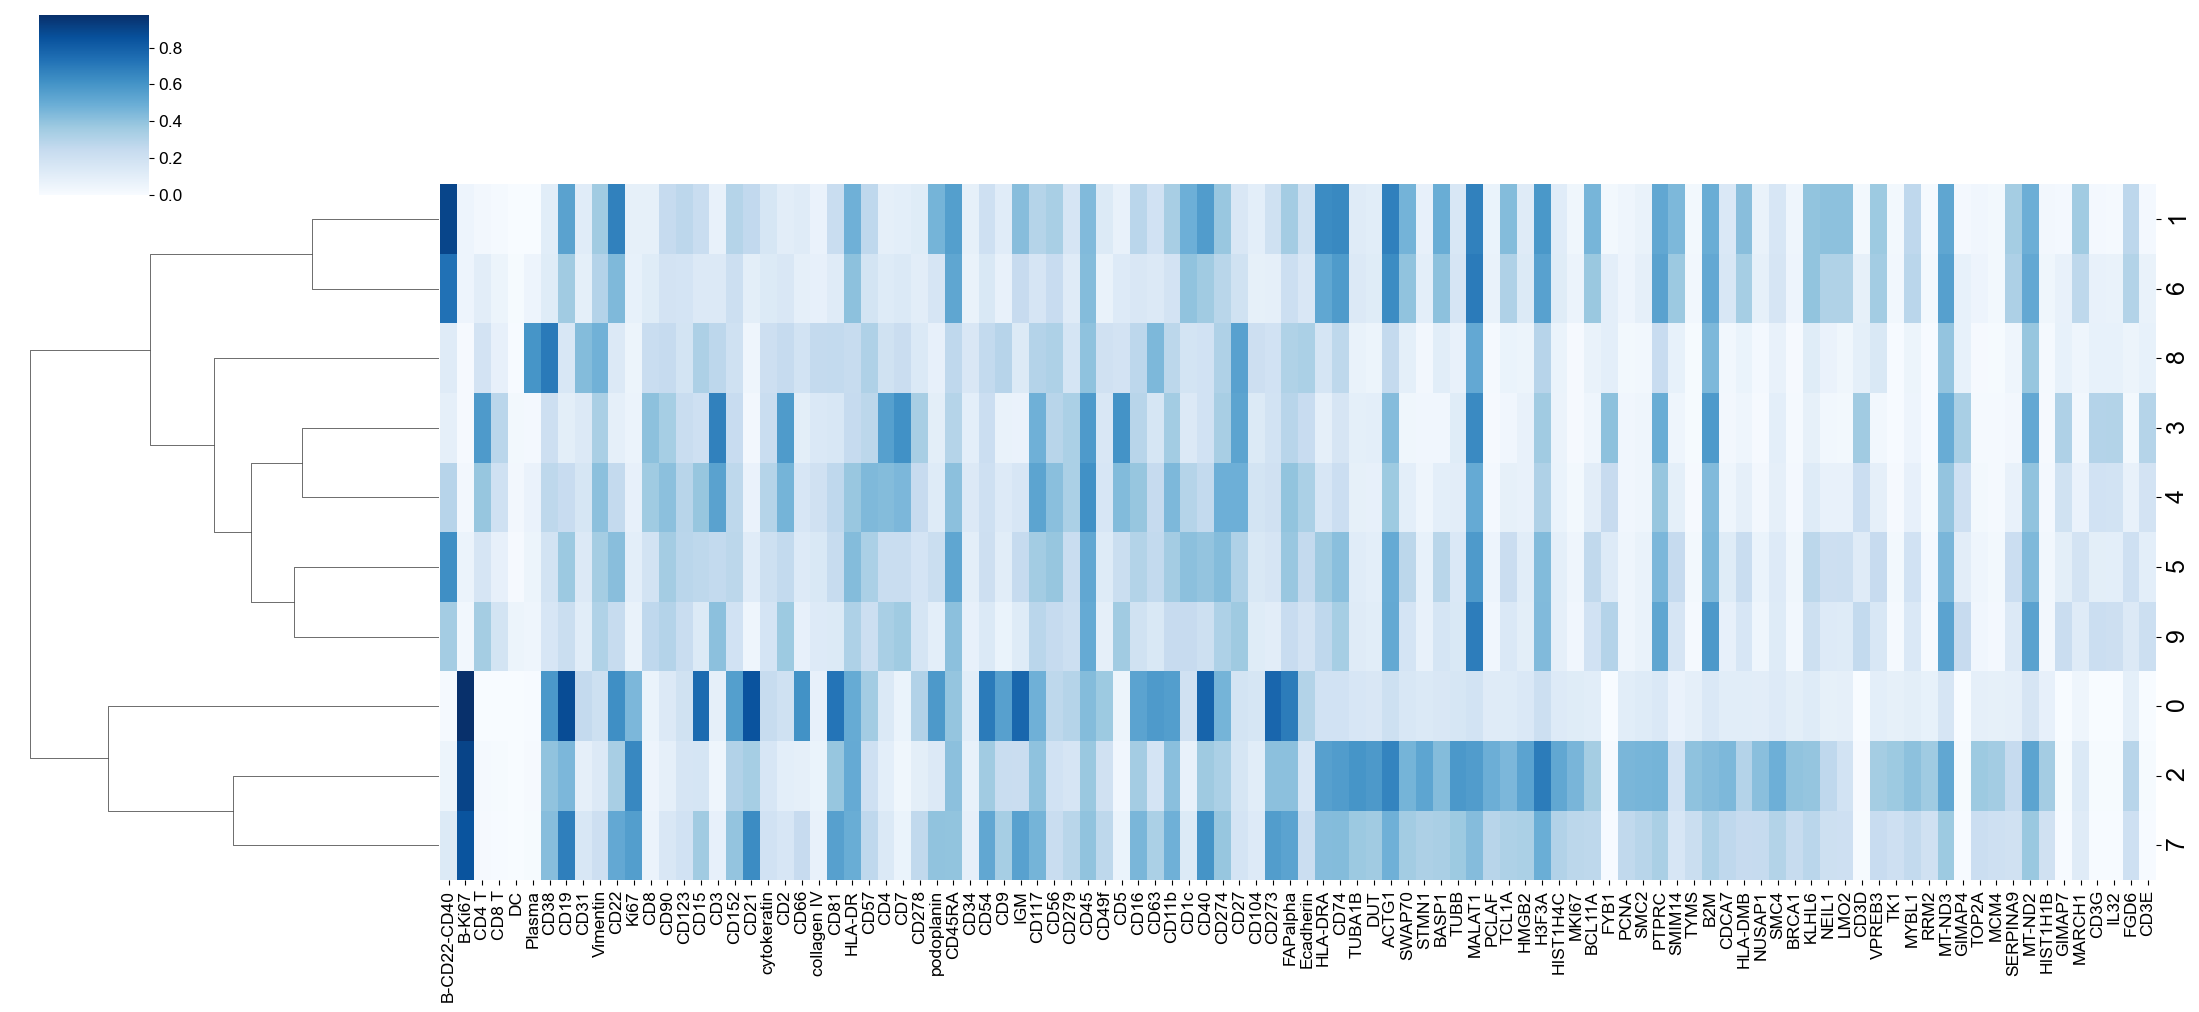

In [55]:
comb_df = pd.concat([cluster_composition, cluster_avg_exp, cluster_avg_exp_rna_variable], axis=1)

fg = sns.clustermap(comb_df, cmap='Blues', figsize=(22,10), 
                    row_cluster = True, 
                    col_cluster=False,
                    xticklabels=True, 
                    yticklabels=True)

fg.cax.yaxis.set_tick_params(labelsize=12.5)

fg.ax_heatmap.set_yticklabels(fg.ax_heatmap.get_yticklabels(), fontsize=18)
fg.ax_heatmap.set_xticklabels(fg.ax_heatmap.get_xticklabels(), fontsize=12.5)

#plt.savefig('../figures/tonsil/tonsil_protein_neighborhood_heatmap.png')
#plt.savefig('../figures/tonsil/tonsil_protein_neighborhood_heatmap.svg', dpi=300)
plt.show()